# Upwork Project
###### Analyze online job postings.

In [1]:
# Import libraries
import numpy as np
np.random.seed(1000) # Set seeds for reproducable results
import pandas as pd
import random
random.seed(1000)
import tensorflow as tf
tf.random.set_seed(1000)
from tensorflow.keras import layers
from tensorflow import keras
import matplotlib.pyplot as plt

In [2]:
# The data is from https://www.kaggle.com/datasets/asaniczka/all-jobs-on-upwork-200k-plus
pd.read_csv("upwork-jobs.csv")

,title,link,description,published_date,is_hourly,hourly_low,hourly_high,budget,country
0,Experienced Media Buyer For Solar Pannel and R...,https://www.upwork.com/jobs/Experienced-Media-...,We’re looking for a talented and hardworking a...,2024-02-17 09:09:54+00:00,False,NaN,NaN,500.0,NaN
1,Full Stack Developer,https://www.upwork.com/jobs/Full-Stack-Develop...,Job Title: Full Stack DeveloperWe are seeking ...,2024-02-17 09:09:17+00:00,False,NaN,NaN,1100.0,United States
2,SMMA Bubble App,https://www.upwork.com/jobs/SMMA-Bubble-App_%7...,I need someone to redesign my bubble.io site t...,2024-02-17 09:08:46+00:00,True,10.0,30.0,NaN,United States
3,Talent Hunter Specialized in Marketing,https://www.upwork.com/jobs/Talent-Hunter-Spec...,Join Our Growing Team!We are an innovative com...,2024-02-17 09:08:08+00:00,NaN,NaN,NaN,NaN,United States
4,Data Engineer,https://www.upwork.com/jobs/Data-Engineer_%7E0...,We are looking for a resource who can work par...,2024-02-17 09:07:42+00:00,False,NaN,NaN,650.0,India
...,...,...,...,...,...,...,...,...,...
53053,Partial Migration From WordPress to Shopify,https://www.upwork.com/jobs/Partial-Migration-...,We're moving from Wordpress to Shopify. The Sh...,2024-02-14 06:40:39+00:00,False,NaN,NaN,150.0,Australia
53054,Logo work &amp; Event Booth Rendering,https://www.upwork.com/jobs/Logo-work-amp-Even...,I need some art works rendered in to booth des...,2024-02-14 06:40:26+00:00,False,NaN,NaN,30.0,United States
53055,Wedding Dress Collection Photographer,https://www.upwork.com/jobs/Wedding-Dress-Coll...,We are looking for a skilled photographer to c...,2024-02-14 06:40:06+00:00,True,23.0,51.0,NaN,Australia
53056,Design a startup profile,https://www.upwork.com/jobs/Design-startup-pro...,I building a startup company and I want to des...,2024-02-14 06:40:06+00:00,False,NaN,NaN,70.0,Saudi Arabia


In [3]:
data = pd.read_csv("upwork-jobs.csv")
# Clean and process data

# Remove all non-hourly jobs
data.drop(data[data.is_hourly == False].index, inplace=True)
data.dropna(subset=["is_hourly"], inplace=True)

# Remove countries except Canada and United States
data = data.loc[((data["country"] == "United States") | (data["country"] == "Canada"))]

# Drop unneeded columns
data.drop(columns=["link", "published_date", "is_hourly", "budget"], inplace=True)

# Replace nan values for hourly high with hourly low instead
def remove_nan(row):
    if np.isnan(row["hourly_high"]) == True:
        row["hourly_high"] = row["hourly_low"]
    return row
data = data.apply(remove_nan, axis=1)

# Perform z-scale normalization column of data for better performance with models
# Function creates a column with the values normalized
# Returns the dataframe, the standard deviation, and mean to return values to dollars
def normalize(data, col):
    values = np.asarray(data[col])
    mean = np.mean(values)
    std = np.std(values)
    median = np.median(values)
    normalized = np.divide(np.subtract(values, mean), std)
    
    # Add to data as a new column
    data.insert(data.columns.get_loc(col)+1, str("standardized_" + col), normalized)
    return data, std, mean, median

# Normalize the hourly low and high
data, low_std, low_mean, low_median = normalize(data, "hourly_low")
data, high_std, high_mean, high_median = normalize(data, "hourly_high")

print("Hourly low standard deviation, mean, and median:", low_std, low_mean, low_median)
print("Hourly high standard deviation, mean, and median:", high_std, high_mean, high_median)
data

Hourly low standard deviation, mean, and median: 20.373728446377108 19.521969894718524 15.0
Hourly high standard deviation, mean, and median: 51.51793577801877 43.70442878273732 34.0


,title,description,hourly_low,standardized_hourly_low,hourly_high,standardized_hourly_high,country
2,SMMA Bubble App,I need someone to redesign my bubble.io site t...,10.0,-0.467365,30.0,-0.266013,United States
19,Customer Service,We are seeking a highly motivated and skilled ...,4.0,-0.761862,8.0,-0.693049,Canada
24,Linkedin Ads Coach,"Hi there, I need a Linkedin Ads coach to work ...",15.0,-0.221951,50.0,0.122202,United States
27,CapCut genius,I need someone who can take plain videos and t...,6.0,-0.663696,15.0,-0.557174,United States
29,Social media pro to write and post to instagram,Expertise in social media posts and marketing ...,5.0,-0.712779,15.0,-0.557174,United States
...,...,...,...,...,...,...,...
53035,Instagram Lead Generation Specialist,Looking for Instagram lead generation speciali...,3.0,-0.810945,5.0,-0.751281,United States
53038,Shopify Expert Needed for Google Email Domain ...,We are seeking a skilled Shopify expert to ass...,10.0,-0.467365,20.0,-0.460120,Canada
53040,Virtual personal assistant position,This position is flexible and can be occupied ...,60.0,1.986776,100.0,1.092737,United States
53045,Back End Developer for Legislative Tracking Ap...,We are seeking a skilled Back End Developer to...,16.0,-0.172868,35.0,-0.168959,United States


In [4]:
# Create bag of words using the job titles
# The key is the word, the value is the number of occurences
bag = {}

# Save the individual words for 1-hot encoding later
title_words = []

# Loop through each entry
for entry in data.itertuples():
    title = [] # save this entry here
    words = str(entry[1])
    
    # Remove symbols to normalize terms like full-stack to fullstack, or react.js to reactjs
    for term in ["-", "(", ")", "]", "[", "\\", "|", "."]:
        words = words.replace(term, "")
        
    # Separate words so terms like C/C++ becomes 2 separate words
    for term in ["/", ","]:
        words = words.replace(term, " ")
        
    words = words.split(" ") # Convert to list of terms
    
    for word in words:
        word = str(word).lower() # Lowercase all entries
        
        # Skip single characters
        # Most are just "a" or single numbers. C and R are both languages however
        if len(word) <= 1 and word not in ["c","r"]:
            continue
            
        # Skip these common words
        if word in ['for', 'and', 'to', 'needed','with','&amp;','in', 'need','of','on','seeking','an']:
            continue
            
        if word in bag:
            bag[word] += 1
        else:
            bag[word] = 1
        title.append(word) # Add word to title list for later
    title_words.append(title)

In [5]:
# Examine some specific terms
print("There are", len(bag), "unique words")
for keyword in ["developer", "software", "programmer", "ai", "app", "c++", "fullstack"]:
    print(keyword, ":", bag[keyword])

There are 7467 unique words
developer : 790
software : 125
programmer : 21
ai : 167
app : 299
c++ : 8
fullstack : 34


In [6]:
# Reduce the number of unique words
# Sort bag by number of occurences in order of most common to least
shortlist = sorted(bag, key=bag.get, reverse=True)

# Remove words with 5 or less appearances
for word, count in bag.items():
    if count <= 5:
        shortlist.remove(word)
        
# Show most prevalent terms
print("Ten most common terms:")

i = 0
for s in shortlist:
    print(s, ":", bag[s])
    i += 1
    if i == 10:
        break
print("Out of", len(shortlist), "words.")

Ten most common terms:
developer : 790
expert : 774
website : 684
designer : 641
specialist : 595
assistant : 593
design : 552
media : 538
video : 533
marketing : 522
Out of 1377 words.


In [7]:
# Create 1-hot encoding using the words in the job titles and the short list of more common terms
# Each job title will be converted to a numpy array of zeros equal to the number of unique words + 1
# Each index represents a word and is set to 1 if the job title contains that word
# returns a list of numpy arrays
def encode(title_words, shortlist):
    encoding_list = []   
    for title in title_words:
        encoding = np.zeros(len(shortlist)+1) # plus one in case no words match
        no_matches = True
        for word in title:
            if word in shortlist:
                encoding[shortlist.index(word)] = 1
                no_matches = False
        if no_matches == True:
            encoding[-1] = 1 # Set the last value to 1 to signify no title words are encoded
        encoding_list.append(encoding)
    return encoding_list
encoding_list = encode(title_words, shortlist)

In [8]:
# Get the values to predict; the wages
low_wage = np.array(data.loc[:,"standardized_hourly_low"])
high_wage = np.array(data.loc[:,"standardized_hourly_high"])
job_titles = list(data.loc[:,"title"])

# Access these 3 lists using a list of randomized indices to shuffle
indices = list(range(len(encoding_list)))
random.shuffle(indices)

# Reserve 20% of entries as the validation set
training_indices = indices[0:int(len(indices) // 1.25)]
testing_indices = indices[int(len(indices) // 1.25): len(indices)]

# Create lists for training and testing
train_words = []
train_low = []
train_high = []
train_titles = [] # Stores list with the full title and bag of words version

test_words = []
test_low = []
test_high = []
test_titles = []

for i in training_indices:
    train_words.append(encoding_list[i])
    train_low.append(low_wage[i])
    train_high.append(high_wage[i])
    train_titles.append([job_titles[i], title_words[i]])

for i in testing_indices:
    test_words.append(encoding_list[i])
    test_low.append(low_wage[i])
    test_high.append(high_wage[i])
    test_titles.append([job_titles[i], title_words[i]])

# Convert to numpy arrays
train_words = np.array(train_words)
train_low = np.array(train_low)
train_high = np.array(train_high)

test_words = np.array(test_words)
test_low = np.array(test_low)
test_high = np.array(test_high)

In [9]:
# Neural network for predicting hourly low using job title
# Linear activation function for middle layer and output, since all values are near 0
# follows https://keras.io/guides/training_with_built_in_methods/
# Create model
inputs = keras.Input(shape=(len(shortlist) + 1,), name="title_word_encoding")
hidden_layer = layers.Dense(1024, activation="linear", name="hidden")(inputs)
outputs = layers.Dense(1, activation="linear", name="output")(hidden_layer)

model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

# Compile
model.compile(
    optimizer=keras.optimizers.SGD(),
    loss=keras.losses.Huber(),
    metrics=[keras.metrics.MeanSquaredError(name="mean_squared_error", dtype=None)
],
)

# Fit Model
history = model.fit(
    train_words,
    train_low,
    batch_size=1,
    epochs=10,
    validation_data=(test_words, test_low),
)
history.history

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
title_word_encoding (InputLa [(None, 1378)]            0         
_________________________________________________________________
hidden (Dense)               (None, 1024)              1412096   
_________________________________________________________________
output (Dense)               (None, 1)                 1025      
Total params: 1,413,121
Trainable params: 1,413,121
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
9194/9194 [==============================] - 20s 2ms/step - loss: 0.2634 - mean_squared_error: 0.9689 - val_loss: 0.2319 - val_mean_squared_error: 0.7532
Epoch 2/10
9194/9194 [==============================] - 19s 2ms/step - loss: 0.2460 - mean_squared_error: 0.8770 - val_loss: 0.2346 - val_mean_squared_error: 0.7516
Epoch 3/10
9194/9194 [======================

{'loss': [0.26337361335754395,
  0.24601633846759796,
  0.23899374902248383,
  0.2345859706401825,
  0.23018620908260345,
  0.22695091366767883,
  0.2248418629169464,
  0.22266517579555511,
  0.22043834626674652,
  0.21873965859413147],
 'mean_squared_error': [0.9688666462898254,
  0.8770143985748291,
  0.8247097730636597,
  0.7925747036933899,
  0.7592350244522095,
  0.7349551916122437,
  0.7146348357200623,
  0.7015784382820129,
  0.6894142031669617,
  0.6868451833724976],
 'val_loss': [0.2318887859582901,
  0.23458035290241241,
  0.23255036771297455,
  0.25396525859832764,
  0.2367217093706131,
  0.23714926838874817,
  0.2337290495634079,
  0.24613888561725616,
  0.23741236329078674,
  0.23767341673374176],
 'val_mean_squared_error': [0.753160834312439,
  0.7515813708305359,
  0.7143323421478271,
  0.7095006108283997,
  0.7172926068305969,
  0.691692054271698,
  0.6828567385673523,
  0.6867580413818359,
  0.7086479663848877,
  0.6861398816108704]}

In [10]:
# Convert normalized feature back to normal
# Uses the standard deviation and mean of the low/high wage
def convert(value, std, mean):
    return float((value * std) + mean)

# Compare the difference between predicted and actual wages
def model_test(predictions, answers, std, mean, titles, count = 0):
    error = []
    stats = [] # 2d list with error, x, y, titles
    for i in range(len(predictions)):
        x = convert(predictions[i], std, mean)
        y = convert(answers[i], std, mean)
        
        # Print out examples
        if count > 0:
            print("Predicted: %.2f" % (x), end=" ")
            print("| Actual: %.2f" % (y), end="")
            print("\nJob:", titles[i][0], "\nEncoding:", titles[i][1], "\n")
            count -= 1

        error.append(abs(x-y))
        temp = [abs(x-y), x, y, titles[i][0], titles[i][1]]
        stats.append(temp)
        
    # Find the 10 worst cases
    top_ten = sorted(stats, reverse=True)[0:10]
    
    # Do error stats
    # Mean, stdev for error
    mean_error = np.mean(error)
    std_error = np.std(error)
    
    return std_error, mean_error, top_ten
        
# Testing stats
print(" Testing set examples:")
std_error, mean_error, top_ten = model_test(model.predict(test_words), test_low, low_std, low_mean, test_titles, count=5)

# Training stats
print(" Training set examples:")
train_std_error, train_mean_error, train_top_ten = model_test(model.predict(train_words), train_low, low_std, low_mean, train_titles, count=5)


 Testing set examples:
Predicted: 33.54 | Actual: 28.00
Job: AR/VR Developer 
Encoding: ['ar', 'vr', 'developer'] 

Predicted: 15.87 | Actual: 20.00
Job: Build an ecommerce website 
Encoding: ['build', 'ecommerce', 'website'] 

Predicted: 21.26 | Actual: 35.00
Job: Paper pattern 
Encoding: ['paper', 'pattern'] 

Predicted: 29.26 | Actual: 100.00
Job: Headshots for Corporate Team Members 
Encoding: ['headshots', 'corporate', 'team', 'members'] 

Predicted: 24.28 | Actual: 25.00
Job: Hiring Developer To Help Build Stock/Finance News Website 
Encoding: ['hiring', 'developer', 'help', 'build', 'stock', 'finance', 'news', 'website'] 

 Training set examples:
Predicted: 9.96 | Actual: 5.00
Job: Professional Real Estate Virtual Assistant 
Encoding: ['professional', 'real', 'estate', 'virtual', 'assistant'] 

Predicted: 22.13 | Actual: 15.00
Job: Mobile App Developer for Home Exchange App 
Encoding: ['mobile', 'app', 'developer', 'home', 'exchange', 'app'] 

Predicted: 19.28 | Actual: 10.00
Jo

###### Note that the model can predict a negative number, which does not make sense for an hourly wage.
###### Because the values are normalized, many of the outputs are negative numbers near 0
###### A custom activation function for the final layer that sets a floor to the value corresponding to the lowest wage would fix this

In [11]:
print("Stats for validation set (the model was not trained on these jobs)")
print("Prediction standard deviation:",std_error)
print("Prediction mean error:",mean_error, end="\n\n")
print("Worst case outliers\n")
for e in top_ten:
    print("Predicted: %.2f" % (e[1]), end=" ")
    print("| Actual: %.2f" % (e[2]), end="")
    print("\nJob Title:", e[3])
    print("Encoded form:", e[4], end="\n\n")

Stats for validation set (the model was not trained on these jobs)
Prediction standard deviation: 12.938367471427004
Prediction mean error: 10.835483211286693

Worst case outliers

Predicted: 28.61 | Actual: 200.00
Job Title: I need a cleaner urgently for a two bed room flat apartment  interested text me  +14752395291
Encoded form: ['cleaner', 'urgently', 'two', 'bed', 'room', 'flat', 'apartment', 'interested', 'text', 'me', '+14752395291']

Predicted: 35.35 | Actual: 200.00
Job Title: Asset Manager
Encoded form: ['asset', 'manager']

Predicted: 160.71 | Actual: 3.00
Job Title: Independent Contractors Customer Service
Encoded form: ['independent', 'contractors', 'customer', 'service']

Predicted: 43.76 | Actual: 200.00
Job Title: Non-Disclosure or Confidentiality Agreement and Fee Agreement for Real Estate Brokerage Needed
Encoded form: ['nondisclosure', 'or', 'confidentiality', 'agreement', 'fee', 'agreement', 'real', 'estate', 'brokerage']

Predicted: 39.98 | Actual: 150.00
Job Title

In [12]:
print("Stats for training set (the model saw these jobs several times)")
print("Prediction standard deviation:",train_std_error)
print("Prediction mean error:",train_mean_error, end="\n\n")
print("Worst case outliers\n")
for e in train_top_ten:
    print("Predicted: %.2f" % (e[1]), end=" ")
    print("| Actual: %.2f" % (e[2]), end="")
    print("\nJob Title:", e[3])
    print("Encoded form:", e[4], end="\n\n")

Stats for training set (the model saw these jobs several times)
Prediction standard deviation: 13.100115030464607
Prediction mean error: 9.800936120215617

Worst case outliers

Predicted: 19.59 | Actual: 300.00
Job Title: Dermatologist for dry eye skincare
Encoded form: ['dermatologist', 'dry', 'eye', 'skincare']

Predicted: 14.98 | Actual: 230.00
Job Title: 100 images to word
Encoded form: ['100', 'images', 'word']

Predicted: 9.77 | Actual: 200.00
Job Title: Customer Service Rep
Encoded form: ['customer', 'service', 'rep']

Predicted: 11.73 | Actual: 200.00
Job Title: Sales Call Closer For Short Form Agency
Encoded form: ['sales', 'call', 'closer', 'short', 'form', 'agency']

Predicted: 18.81 | Actual: 200.00
Job Title: Marketing
Encoded form: ['marketing']

Predicted: 20.12 | Actual: 200.00
Job Title: Software development c++
Encoded form: ['software', 'development', 'c++']

Predicted: 20.59 | Actual: 200.00
Job Title: AI Generated Video Spokesperson
Encoded form: ['ai', 'generated'

###### The model is not very precise but generally guesses a reasonably near number.
###### The job outliers include unusual jobs with uncommon words. Many are not permanent jobs but short term tasks.
###### The wages are either over 100 per hour, which is substantially higher than most jobs, or extremely low.
###### Removing these outlier jobs would improve model performance
######
###### Performance is similar between training and validation sets. Rather than overfitting, the model could benefit from more training iterations.

In [13]:
# Get average wage from data based on words in job title
# ["software", "developer"] will match all jobs with those terms and more (ie senior software developer)
# Returns a list containing the hourly wages
def average_wage(title_words, job, hourly_wage):
    wages = []
    for i in range(len(title_words)):
        matching = True
        for word in job:
            if word not in title_words[i]:
                matching = False
                break
                
        if matching == True:
            # Add wage to list
            wages.append(hourly_wage[i])
    return wages

example_jobs = [["software", "developer"],["app"],["web", "developer"], 
                ["full", "stack"], ["data", "analyst"], ["database"],
               ["developer"], ["website"]]
labels = []
for job in example_jobs:
    label = ""
    for word in job:
        label += (str(word) + " ")
    label = label.strip(" ")
    labels.append(label)

example_wages = []
predictions = []
# Predict the wage using the example job words and compare against actual job wages
for job in example_jobs:
    example_wages.append(average_wage(title_words, job, list(data.loc[:,"hourly_low"])))
    encoded_job = np.array(encode([job], shortlist))
    prediction = model.predict(encoded_job)
    prediction = convert(prediction, low_std, low_mean)
    predictions.append(prediction)
    
for i in range(len(example_wages)):
    print(labels[i], "\nMean wage:", end="")
    print(" %.2f | Median wage: %.2f" % (np.mean(example_wages[i]), np.median(example_wages[i])), end="")
    print(" | Predicted %.2f" % predictions[i], end="")
    print(" | Total of", len(example_wages[i]), "jobs with these keywords\n")

software developer 
Mean wage: 19.56 | Median wage: 15.00 | Predicted 22.40 | Total of 18 jobs with these keywords

app 
Mean wage: 20.51 | Median wage: 15.00 | Predicted 18.31 | Total of 288 jobs with these keywords

web developer 
Mean wage: 19.67 | Median wage: 15.00 | Predicted 17.98 | Total of 97 jobs with these keywords

full stack 
Mean wage: 24.90 | Median wage: 25.00 | Predicted 22.80 | Total of 99 jobs with these keywords

data analyst 
Mean wage: 26.18 | Median wage: 19.00 | Predicted 25.22 | Total of 22 jobs with these keywords

database 
Mean wage: 23.36 | Median wage: 18.50 | Predicted 20.23 | Total of 42 jobs with these keywords

developer 
Mean wage: 21.72 | Median wage: 16.00 | Predicted 19.11 | Total of 788 jobs with these keywords

website 
Mean wage: 17.86 | Median wage: 15.00 | Predicted 17.30 | Total of 670 jobs with these keywords



###### For these standard jobs, the prediction is quite close to either the mean or median wage.

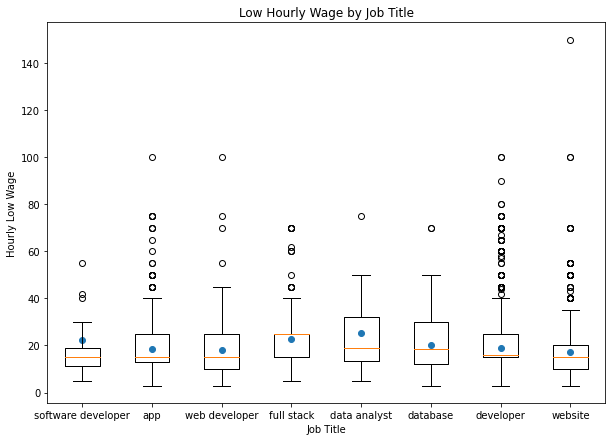

In [14]:
figure, axis = plt.subplots(figsize=(10,7))
axis.boxplot(example_wages)
plt.xticks(range(1,len(labels)+1), labels, rotation='horizontal')
plt.xlabel('Job Title')
plt.ylabel('Hourly Low Wage')
plt.title('Low Hourly Wage by Job Title')
axis.scatter(range(1,len(labels)+1), predictions)
plt.show()

###### The blue dots represent the model's wage prediction. The box plot represents the data for all listings of that category.
###### Generally the guesses are in the box, so within the first and third quantile.
###### The prediction for software developer is slightly too high, but there are higher wage outliers and very few cases over all (18).

### Conclusions
###### Using the job titles to predict wages results in reasonably close guesses.
###### Titles alone are not great predictors for wage. While it may be expected that a job with "expert" in the title implies a high wage, this is not case.
###### Model performances could be signficantly improved by:
1. Removing outlier data
- Jobs with substantially higher hourly pay
- Jobs that are just gigs or temporary
2. Using natural language processing
- Job descriptions contain lots of valuable data such as desired experience and skills
- Can be used to filter out jobs that are not hourly or permanent that are otherwise listed as such